# ROMS model data

DOPPIO is a regional model (ROMS) run at rutgers by John Wilkin's group to forecast the state of the Gulf of Maine / mid atlantic bight. 


The data is available on a thredds server:

http://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/2017_da/avg/Averages_Best

## working with grids
This notebook is my attempt to learn about the ROMS grid and how to make plots. More below info below. 



# Grids

ROMS uses a C-grid, common for ocean models, which means the the velocities, and scalars are actually on a different grid (**note:** actually this doppio output has `v_northward` and `u_eastward` on the center grid, but more generally this isn't true). In addition its vertical coordinate is not depth. These grid things really matter if we want to make plots of velocity, vertical slices, or calculate anything about our grid. 

I'm not *at all* an expert in modeling or these grids. I'm just interested in trying to make some simple plots. I've been looking at these resources to try to understand how to work with the ROMS grid in python:

xarray example: http://xarray.pydata.org/en/scipy19-docs/examples/ROMS_ocean_model.html

discussion on xgcm: https://github.com/xgcm/xgcm/issues/108

xgcm in general: https://xgcm.readthedocs.io/en/latest/index.html

I think in combo these sources are really helpful. I'm going to try to puzzle through working with the grid useing these ideas. 


In [35]:
import xarray as xr
import matplotlib.pyplot as plt

import seawater as sw
import numpy as np

import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

%matplotlib inline

# read in the data

available at:
```python
url = 'http://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/2017_da/avg/Averages_Best'
```


I'm only grabbing a single day for now while I play with things

In [3]:
url = 'http://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/2017_da/avg/Averages_Best'

ds = xr.open_dataset(url).sel(time = '2019-07-21', method = 'nearest').squeeze()

ds

<xarray.Dataset>
Dimensions:         (boundary: 4, eta_psi: 105, eta_rho: 106, eta_u: 106, eta_v: 105, s_rho: 40, s_w: 41, tracer: 2, xi_psi: 241, xi_rho: 242, xi_u: 241, xi_v: 242)
Coordinates:
  * s_rho           (s_rho) float64 -0.9875 -0.9625 -0.9375 ... -0.0375 -0.0125
  * s_w             (s_w) float64 -1.0 -0.975 -0.95 -0.925 ... -0.05 -0.025 0.0
    lon_rho         (eta_rho, xi_rho) float64 ...
    lat_rho         (eta_rho, xi_rho) float64 ...
    lon_u           (eta_u, xi_u) float64 ...
    lat_u           (eta_u, xi_u) float64 ...
    lon_v           (eta_v, xi_v) float64 ...
    lat_v           (eta_v, xi_v) float64 ...
    lon_psi         (eta_psi, xi_psi) float64 ...
    lat_psi         (eta_psi, xi_psi) float64 ...
    ocean_time      datetime64[ns] 2019-10-02T12:00:00
    time            datetime64[ns] 2019-07-21T12:00:00
    time_run        datetime64[ns] ...
Dimensions without coordinates: boundary, eta_psi, eta_rho, eta_u, eta_v, tracer, xi_psi, xi_rho, xi_u, xi_v
Dat

# first, get a depth grid from s_rho:
following xarray example: http://xarray.pydata.org/en/scipy19-docs/examples/ROMS_ocean_model.html

If we want to plot anything vs depth we need to convert from `s_rho` to depth

$Z_0 = (h_c \, S + h \,C) / (h_c + h)$

$z = Z_0 (\zeta + h) + \zeta$


This transformation takes a while. Probably need to subset the data first so you don't do it on everything.

In [4]:

if ds.Vtransform == 1:
    Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
    z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
elif ds.Vtransform == 2:
    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
    z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho

ds.coords['z_rho'] = z_rho.transpose()   
ds.salt

<xarray.DataArray 'salt' (s_rho: 40, eta_rho: 106, xi_rho: 242)>
[1026080 values with dtype=float64]
Coordinates:
  * s_rho       (s_rho) float64 -0.9875 -0.9625 -0.9375 ... -0.0375 -0.0125
    lon_rho     (eta_rho, xi_rho) float64 -75.19 -75.13 -75.08 ... -64.62 -64.54
    lat_rho     (eta_rho, xi_rho) float64 32.24 32.28 32.32 ... 46.58 46.61
    ocean_time  datetime64[ns] 2019-10-02T12:00:00
    time        datetime64[ns] 2019-07-21T12:00:00
    time_run    datetime64[ns] 2019-07-20T12:00:00
    z_rho       (s_rho, xi_rho, eta_rho) float64 -3.838e+03 -3.788e+03 ... nan
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:      time-averaged salinity
    time:           ocean_time
    grid:           grid
    location:       face
    field:          salinity, scalar, series
    _ChunkSizes:    [  1  20  53 121]
    standard_name:  sea_water_salinity

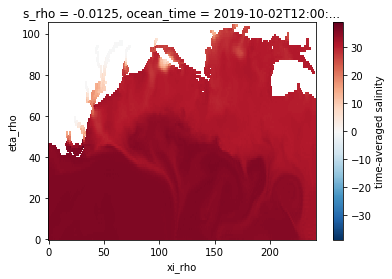

In [6]:
# just want to look at the grid in its _rho coords
plt.figure()
ds.salt.sel(s_rho=0, method='nearest').plot()

# plot a vertical slice

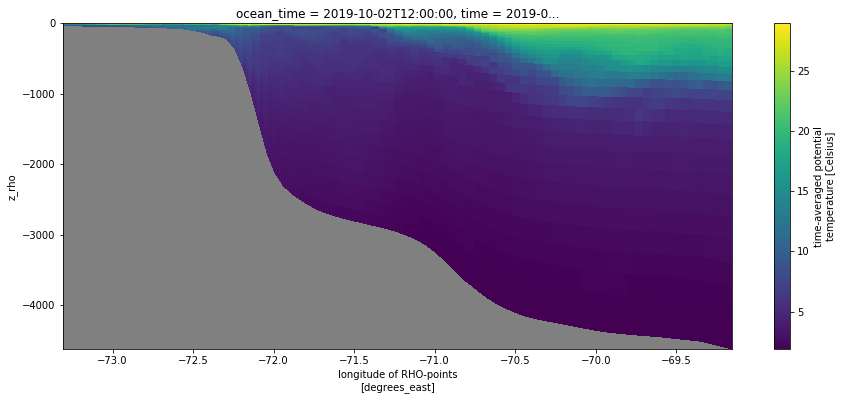

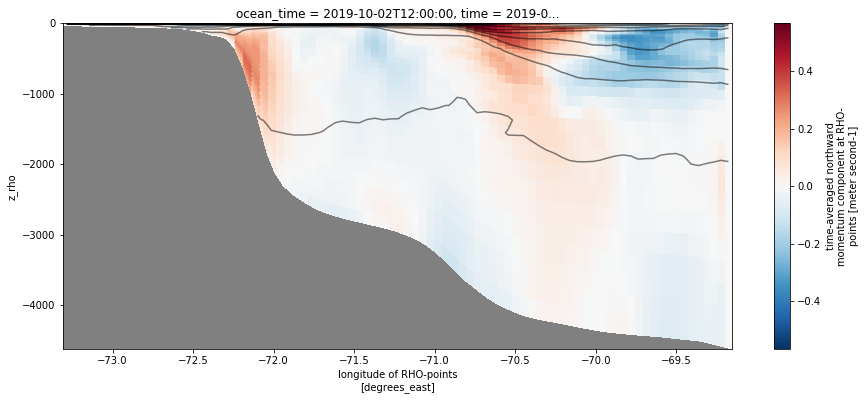

In [52]:
section = ds.isel(xi_rho=100, eta_rho=slice(0, 85)) # can't go into the nan coords (ie on land) and have the plot work...

pres = sw.pres(section.z_rho, section.lat_rho)

rho = sw.pden(section.salt, section.temp, pres)

LON = np.tile(section.lon_rho,(section.z_rho.shape[0],1))



section.temp.plot(x='lon_rho', y='z_rho', figsize=(15, 6))
plt.gca().set_facecolor('gray')


section.v_northward.plot(x='lon_rho', y='z_rho', figsize=(15, 6))
plt.contour(LON, section.z_rho, rho, 20, colors='k', alpha=0.5)
plt.gca().set_facecolor('gray')

Signature: sw.pden(s, t, p, pr=0)
Docstring:
Calculates potential density of water mass relative to the specified
reference pressure by pden = dens(S, ptmp, PR).

Parameters
----------
s(p) : array_like
       salinity [psu (PSS-78)]
t(p) : array_like
       temperature [℃ (ITS-90)]
p : array_like
    pressure [db].
pr : number
     reference pressure [db], default = 0

Returns
-------
pden : array_like
       potential density relative to the ref. pressure [kg m :sup:3]

Examples
--------
>>> # Data from Unesco Tech. Paper in Marine Sci. No. 44, p22.
>>> import seawater as sw
>>> from seawater.library import T90conv
>>> s = [0, 0, 0, 0, 35, 35, 35, 35]
>>> t = T90conv([0, 0, 30, 30, 0, 0, 30, 30])
>>> p = [0, 10000, 0, 10000, 0, 10000, 0, 10000]
>>> sw.pden(s, t, p)
array([  999.842594  ,   999.79523994,   995.65113374,   996.36115932,
        1028.10633141,  1028.15738545,  1021.72863949,  1022.59634627])

:math:`\sigma_{4}` (at 4000 db)

>>> sw.pden(s, t, p, 4000) - 1000
array([ 19.